
# Time series

## Introduction

A time series is a sequence of measurements from a system that varies in time.

The example we will use is taken from a US researcher called Zachary M. Jones, who collected data from a web site called “Price of Weed” that crowdsources the price, quantity, quality, and location of cannabis transactions (http://www.priceofweed.com/). The goal of his project is to investigate the effect of policy decisions on markets.

## Exploratory analysis

Let's first import a few libraries that we will use during the lesson, and load the dataframe from a text file.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pathlib import Path

mpl.rcParams["figure.dpi"] = 150

Path("plots").mkdir(parents=True, exist_ok=True)

df_raw = pd.read_csv(".lesson/assets/mj-clean.csv", parse_dates=[5])
print(df_raw.dtypes)
df_raw.describe()
df_raw.head()


city                  object
state                 object
price                  int64
amount               float64
quality               object
date          datetime64[ns]
ppg                  float64
state.name            object
lat                  float64
lon                  float64
dtype: object


,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


The DataFrame has a row for each reported transaction and the following
columns:

• city: string city name

• state: two-letter state abbreviation.

• price: price paid in dollars

• amount: quantity purchased in grams

• quality: high, medium, or low quality, as reported by the purchaser

• date: date of report, presumed to be shortly after date of purchase

• ppg: price per gram, in dollars

• state.name: string state name

• lat: approximate latitude of the transaction, based on city name

• lon: approximate longitude of the transaction

Next thing we should do it to transform each group into an equally spaced series by computing the mean daily price per gram. We also should transform the date into a continuous variable, for instance the years from the beginning of the series.


In [7]:
seconds_in_a_year = 356 * 24 * 60 * 60
df_train = (
    df_raw.groupby(["quality", "date"], as_index=False)[["quality", "date", "ppg"]]
    .agg("mean")
    .assign(days=lambda x: (x.date - min(x.date)))
    .assign(years=lambda x: x.days.dt.total_seconds() / seconds_in_a_year)
    .assign(type="train")
)


/tmp/ipykernel_1329/2758367017.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .agg("mean")



`groupby` and `agg` are DataFrame methods that group a dataframe along certain variables and then calculate the summary statistics of others. Since the values of quality are low, medium, and high, we get three groups with those names.

It is always good to visualize the dataframe to understand the type of dataset we are dealing with.


In [8]:
sns.set_theme()
lineplot = sns.relplot(x="date", y="ppg", kind="line", row="quality", data=df_train)
lineplot.savefig("plots/lineplot.png")
plt.clf()


<Figure size 750x2250 with 0 Axes>


Visually, it looks like the price of high quality cannabis is declining during this period, and the price of medium quality is increasing. The price of low quality might also be increasing, but it is harder to tell, since it seems to be more volatile.

## Linear regression for time series

Although there are methods specific to time series analysis, for many problems a simple way to get started is by applying general-purpose tools like linear regression. Let's build a loop that cycles through the different qualities of drug and computes a least squares fit for the prices, returning the model and results objects from StatsModels:



In [9]:
for q in df_train.quality.unique():
    model = smf.ols("ppg ~ years", data=df_train.query("quality == @q"))
    results = model.fit()
    print(f"quality = {q}")
    print(results.summary())


quality = high
                            OLS Regression Results                            
Dep. Variable:                    ppg   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     989.7
Date:                Thu, 23 Feb 2023   Prob (F-statistic):          3.69e-160
Time:                        22:43:41   Log-Likelihood:                -1510.1
No. Observations:                1241   AIC:                             3024.
Df Residuals:                    1239   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4496      0.045    2


The estimated slopes indicate that the price of high quality cannabis dropped by about 71 cents per year during the observed interval; for medium quality it increased by 28 cents per year, and for low quality it increased by 57 cents per year. These estimates are all statistically significant with very small p-values.

We can enhance the loop in a way that the predictions are stored into a dataframe that we can plot:



In [10]:
df_ols = pd.DataFrame()
for q in df_train.quality.unique():
    df_q_train = df_train.query("quality == @q")
    model = smf.ols("ppg ~ years", data=df_q_train)
    results = model.fit()
    df_prediction = (
        df_q_train.assign(ppg=results.fittedvalues)
        .assign(type="predict")
        .assign(quality=q)
    )
    df_fit_predict = pd.concat([df_q_train, df_prediction])
    df_ols = pd.concat([df_ols, df_fit_predict])

Let's plot the prediction:



In [11]:
df_ols.reset_index(drop=True, inplace=True)
lineplot = sns.relplot(
    x="date", y="ppg", kind="line", row="quality", hue="type", data=df_ols
)
lineplot.savefig("plots/lineplot_predict.png")
plt.clf()


<Figure size 912.375x2250 with 0 Axes>


The model seems like a good linear fit for the data; nevertheless, linear regression is not the most appropriate choice for this data:

* First, there is no reason to expect the long-term trend to be linear. In general, prices are determined by supply and demand in a non-linear way

* Second, the linear regression model gives equal weight to all data, recent and past; often we should give more weight to recent data.

* Finally, one of the assumptions of linear regression is that the residuals are uncorrelated noise. With time series data, this assumption is almost always false because successive values are correlated.

Let's look for an alternative that is more appropriate for time series data.

## Moving averages

Most time series analysis is based on the modeling assumption that the observed series is the sum of three components:

* __Trend__: Persistent changes.
* __Seasonality__: Periodic variation.
* __Noise__: Random variation.

Regression is one way to extract the trend from a series, as we saw in the previous section. But if the trend is not a simple function, a good alternative is a moving average. A moving average divides the series into overlapping regions, called windows, and computes the average of the values in each window.

One of the simplest moving averages is the rolling mean, which computes the mean of the values in each window. For example, if the window size is 3, the rolling mean computes the mean of values 0 through 2, 1 through 3, 2 through 4, etc.

`pandas` provides `rolling_mean`, which takes a Series and a window size and returns a new Series.


In [12]:
s1 = pd.Series(np.arange(10))
s1.rolling(window=3).mean()


0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64


Similarly to before, we can calculate the rolling average of our drug usage time series for each of the qualities, and put it together into a dataframe that we can plot.



In [13]:
df_rolling = pd.DataFrame()
for q in df_train.quality.unique():
    df_q_train = df_train.query("quality==@q")
    df_q_rolling = df_q_train.copy()
    df_q_rolling["ppg"] = df_q_rolling["ppg"].rolling(window=30).mean()
    df_q_rolling["type"] = "rolling"
    df_q = pd.concat([df_q_train, df_q_rolling])
    df_rolling = pd.concat([df_rolling, df_q])


In [14]:

df_rolling.reset_index(drop=True, inplace=True)
lineplot = sns.relplot(
    x="date", y="ppg", kind="line", row="quality", hue="type", data=df_rolling
)
lineplot.savefig("plots/lineplot_rolling.png")
plt.clf()


<Figure size 903.375x2250 with 0 Axes>


The rolling mean seems to do a good job of smoothing out the noise and extracting the trend.

## Exponentially-weighted moving average (EWMA)

EWMA computes a weighted average where the most recent value has the highest weight and the weights for previous values drop off exponentially.



In [15]:
df_ewma = pd.DataFrame()
for q in df_train.quality.unique():
    df_q_train = df_train.query("quality==@q")
    df_q_ewma = df_q_train.copy()
    df_q_ewma["ppg"] = df_q_ewma["ppg"].ewm(span=30).mean()
    df_q_ewma["type"] = "ewma"
    df_q = pd.concat([df_q_train, df_q_ewma])
    df_ewma = pd.concat([df_ewma, df_q])

df_ewma.reset_index(drop=True, inplace=True)
lineplot = sns.relplot(
    x="date", y="ppg", kind="line", row="quality", hue="type", data=df_ewma
)
lineplot.savefig("plots/lineplot_ewma.png")
plt.clf()


<Figure size 901.875x2250 with 0 Axes>


## Introduction to autocorrelation

Autocorrelation, also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of the delay. Informally, it is the similarity between observations as a function of the time lag between them.

StatsModels, which we used for linear regression, also provides functions for time series analysis, including acf, which computes the autocorrelation function:



In [16]:
import statsmodels.tsa.stattools as smtsa
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_values = smtsa.acf(df_train.query('quality=="high"').ppg, nlags=365)



The following plots show the ACF of the original time series, the rolling average, and the EWMA. Because they all have a trend, the ACF has positive values for small lags. We will see in the next section that this is not very informative, and we will see ways to transform a time series to extract more information from the ACF. However, we will use a different example, since the current one is too noisy.



<Axes: xlabel='Lag', ylabel='Autocorrelation'>

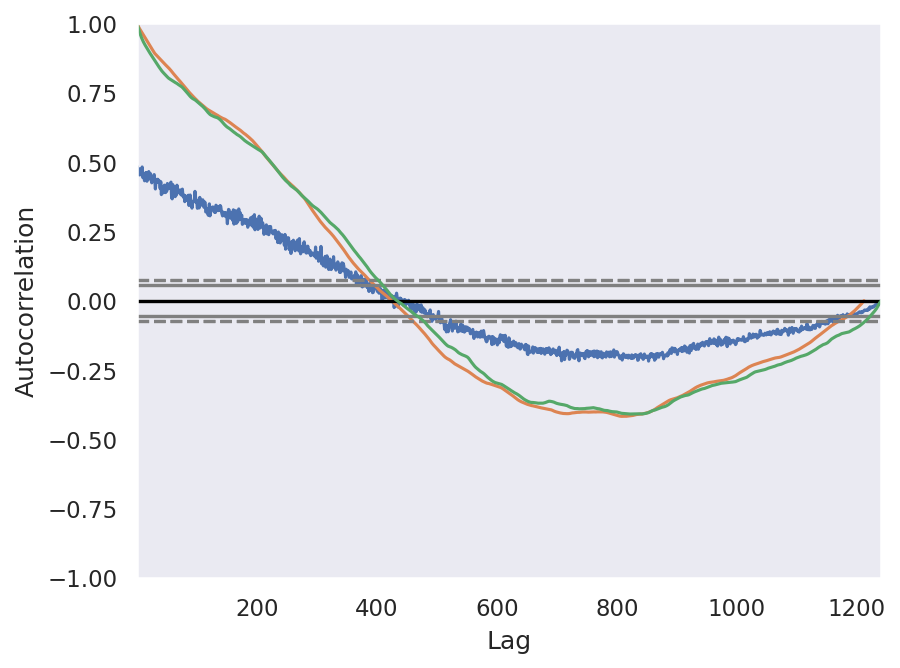

In [17]:
pd.plotting.autocorrelation_plot(
    df_train.query('quality=="high"').dropna().query('type=="train"').ppg
)

pd.plotting.autocorrelation_plot(
    df_rolling.query('quality=="high"').dropna().query('type=="rolling"').ppg
)

pd.plotting.autocorrelation_plot(
    df_ewma.query('quality=="high"').dropna().query('type=="ewma"').ppg
)




## ACF

We will use the `airline-passengers` dataset:



In [18]:
df_flights = pd.read_csv(".lesson/assets/airline-passengers.csv")



If we plot the time series we see that it has a clear upward trend.



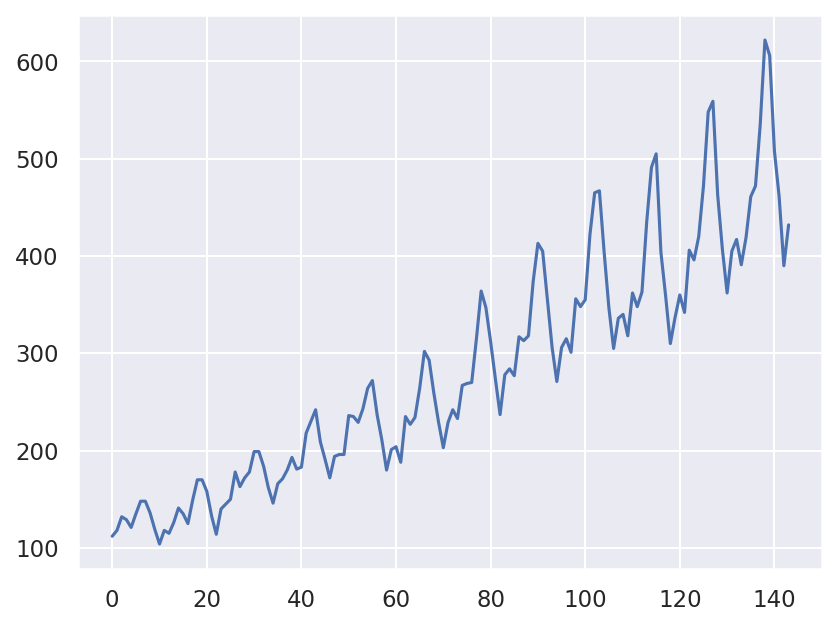

In [19]:
plt.plot(df_flights.Passengers)



As said before, autocorrelation shows the correlation of a sequence with itself lagged by some number of time units. In our example, autocorrelation answers the following question: “How correlated is the number of passengers this month with the number of passengers in the previous month?”. Here, the previous month indicates the lag value of 1.

You can rephrase to question and ask how correlated the number of passengers this month is to the number of passengers a year ago. Then, the lag value would be 12.

One thing to remember — the more lags you use, the lower the correlation will be. More recent periods have more impact.

Before calculating autocorrelation, you should make the time series __stationary__: in a nutshell — the mean, variance, and covariance shouldn’t change over time.

The easiest way to make time series stationary is by calculating the first-order difference:



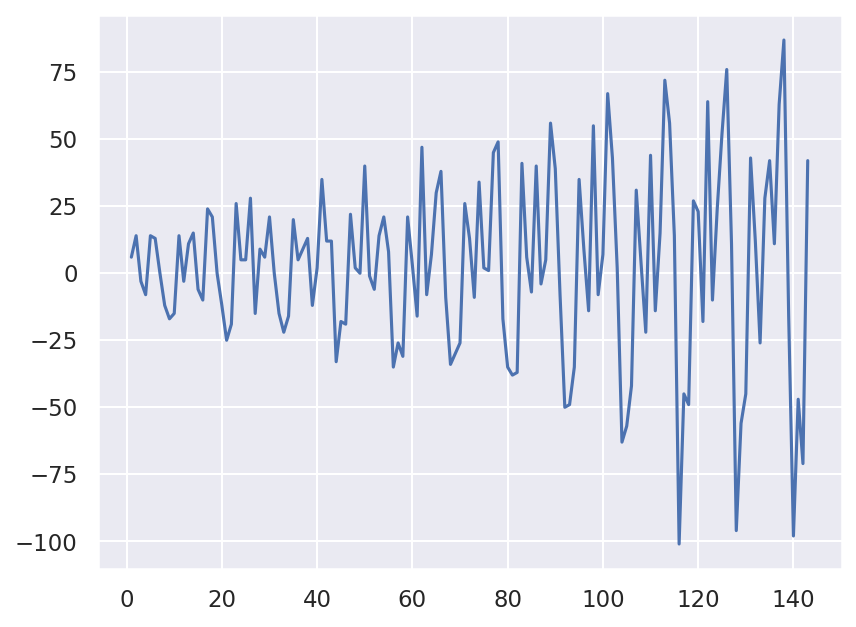

In [20]:
df_flights["Passengers_diff"] = df_flights["Passengers"].diff(periods=1)
plt.plot(df_flights.Passengers_diff)



The differenced series doesn’t look completely stationary but will suit for now. You can now use the `acf()` function from statsmodels to calculate autocorrelation and the `plot_acf()` function to inspect the autocorrelation visually::



[ 1.          0.30285526 -0.10214755 -0.24127349 -0.30040158 -0.09407271
 -0.07844257 -0.0923622  -0.29480158 -0.19177821 -0.10491707  0.28293105
  0.82917786  0.28450079 -0.10575172 -0.22213093 -0.23107603 -0.06227904
 -0.06618505 -0.09039973 -0.29710958 -0.16273198]


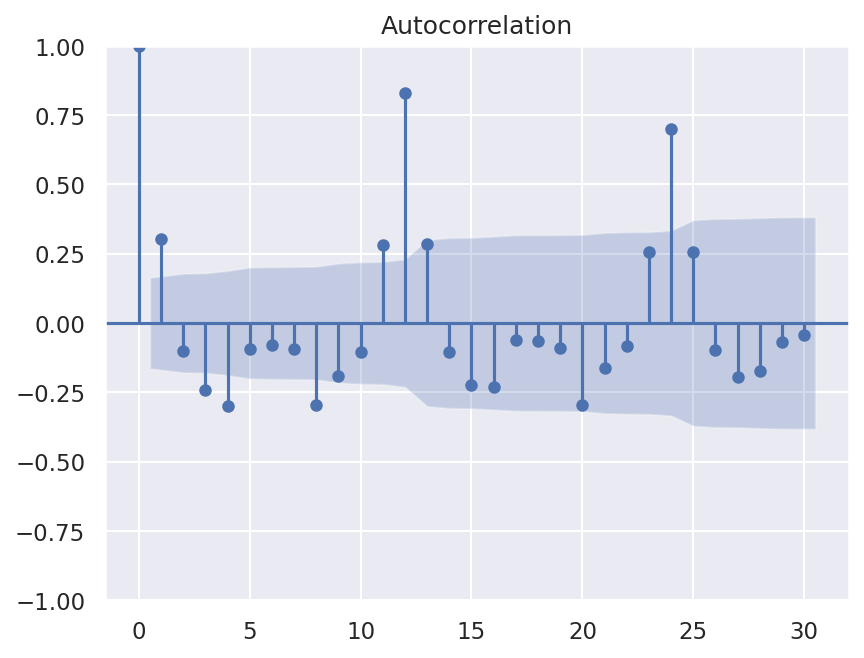

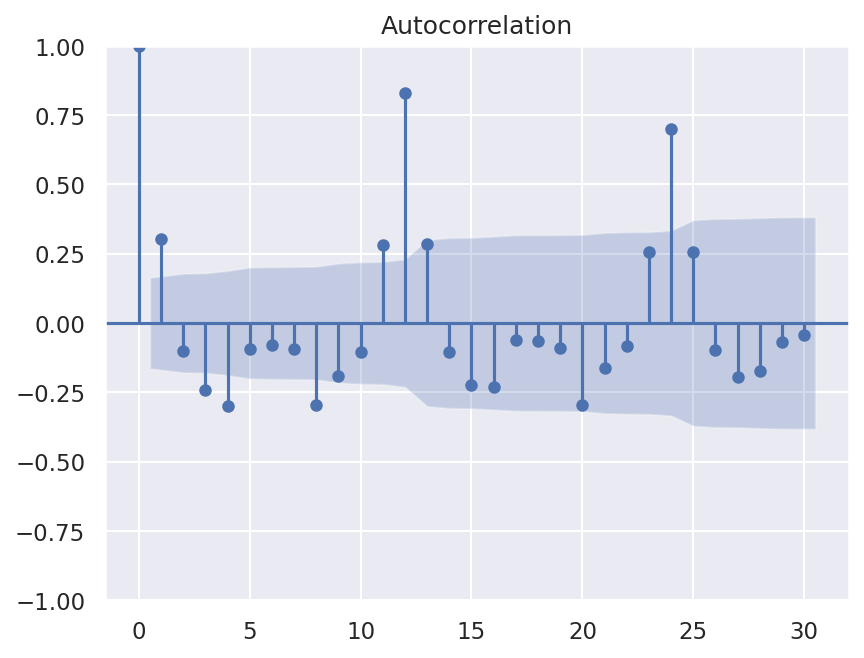

In [21]:
acf_values = acf(df_flights.dropna()["Passengers_diff"])
print(acf_values)
plot_acf(df_flights.dropna().Passengers_diff, lags=30)



The first value is 1, because a correlation between two identical series was calculated. But take a look at as 12th period — autocorrelation value is 0.83. This tells you a value 12 periods ago has a strong impact on the value today.

The plot confirms our assumption about the correlation on lag 12. The same is visible at lag 24, but the correlation declines over time. Value 12 periods ago has more impact on the value today than value 24 periods ago does.

Another thing to note is the shaded area. Anything inside it isn’t statistically significant.

## PACF

PACF shows the correlation of a sequence with itself lagged by some number of time units. But only the direct effect is shown, and all intermediary effects are removed.

For example, you want to know the direct relationship between the number of passengers today and 12 months ago. You don’t care about anything in between.

The number of passengers 12 months affects the number of passengers 11 months ago — and the whole chain repeats until the most recent period. These indirect effects are neglected in partial autocorrelation calculations.

You should also make the time series stationary before calculations. You can use the `pacf()` function from statsmodels for the calculation:



[ 1.          0.30498804 -0.21677838 -0.16414895 -0.22880726  0.0102048
 -0.20039114 -0.16381118 -0.4908729  -0.27906007 -0.67292181 -0.41858338
  0.60762779 -0.05342571 -0.30073394  0.02024145  0.13861772  0.09074817
 -0.12191529  0.01046262 -0.21763101 -0.12181244]


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


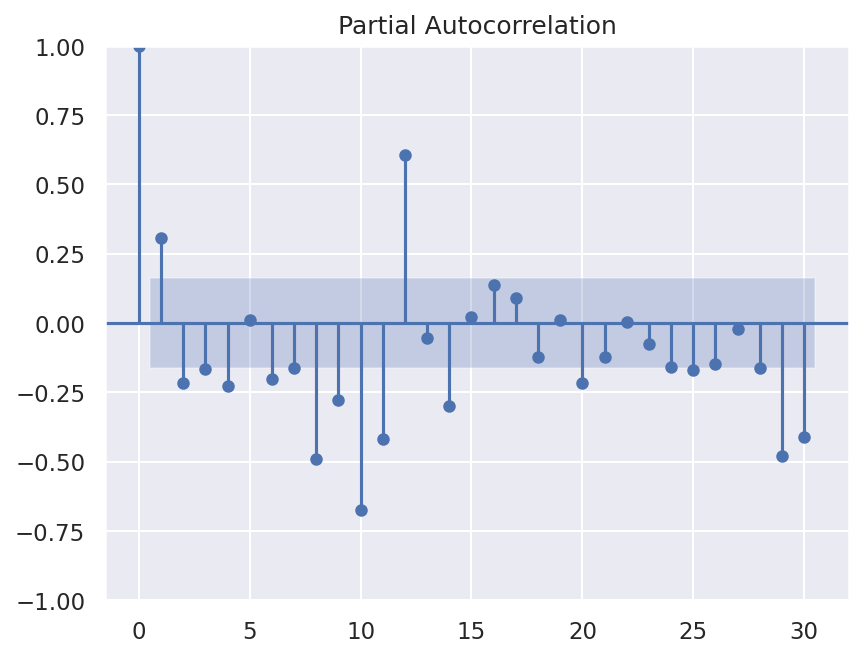

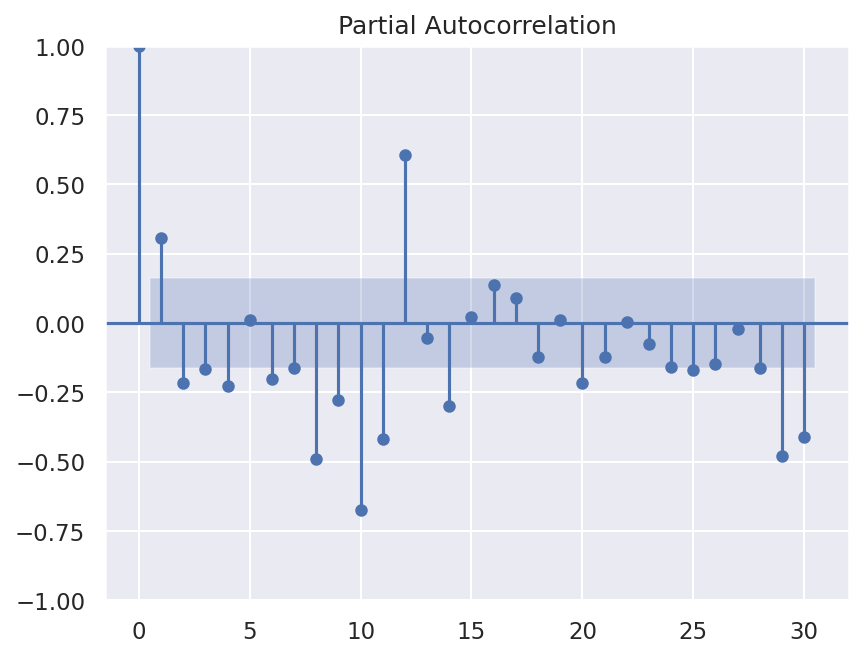

In [22]:
pacf_values = pacf(df_flights.dropna()["Passengers_diff"])
print(pacf_values)
plot_pacf(df_flights.dropna().Passengers_diff, lags=30)



The lag 12 is still significant, but the lag at 24 isn’t. A couple of lags before 12 are negatively correlated to the original time series.

## Conclusions

Time series models we will soon learn about, such as Auto Regression (AR), Moving Averages (MA), or their combinations (ARMA), require you to specify one or more parameters. These can be obtained by looking at ACF and PACF plots. These are some rule of thumb (you do not need to memorize them):

* If the ACF plot declines gradually and the PACF drops instantly, use Auto Regressive model.

* If the ACF plot drops instantly and the PACF declines gradually, use Moving Average model.

* If both ACF and PACF decline gradually, combine Auto Regressive and Moving Average models (ARMA).

* If both ACF and PACF drop instantly (no significant lags), it’s likely you won’t be able to model the time series.

Still, reading ACF and PACF plots is challenging, and you’re far better of using grid search to find optimal parameter values. An optimal parameter combination has the lowest error (such as MAPE) or lowest general quality estimator (such as AIC). Both ACF and PACF require stationary time series.

